<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/june20_1_r_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500

import requests
from scipy import stats

import lightgbm as lgb

# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, GroupKFold
from sklearn.multioutput import RegressorChain


import requests
import time
from scipy import stats

import lightgbm as lgb
# import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')


from itertools import combinations, permutations, combinations_with_replacement


In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

train = pd.read_csv(train_datalink_X) # X
target = pd.read_csv(train_datalink_y) # y
test = pd.read_csv(hackathon_data_link)

train.columns = train.columns.str.lower()
target.columns = target.columns.str.lower()
test.columns = test.columns.str.lower()

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [ ]:
# train.shape, test.shape

((624650, 50), (3746, 50))

In [ ]:
# train_all = pd.concat([train, target], axis=1)

In [ ]:
# moons = [557, 558]
# test = train_all[train_all.moons.isin(moons)]

In [ ]:
# test_target = test[['target_r', 'target_g', 'target_b']]
# test = test.drop(columns = ['target_r', 'target_g', 'target_b'] )

In [ ]:
# train_all.drop(test.index, inplace=True)

In [ ]:
# train = train_all.drop(columns = ['target_r', 'target_g', 'target_b'] )
# target = train_all[['target_r', 'target_g', 'target_b']]

In [3]:
r = train.corrwith(target.target_r, method='spearman')
g = train.corrwith(target.target_g, method='spearman')
b = train.corrwith(target.target_b, method='spearman')

In [4]:
r.sort_values()

feature_32   -0.023317
feature_30   -0.022804
feature_31   -0.022050
feature_29   -0.021814
feature_34   -0.021716
feature_33   -0.021668
feature_35   -0.021525
feature_14   -0.020593
feature_13   -0.020227
feature_17   -0.019305
feature_18   -0.018226
feature_15   -0.017483
feature_20   -0.017438
feature_8    -0.017181
feature_11   -0.017151
feature_10   -0.016753
feature_21   -0.016385
feature_12   -0.016275
feature_19   -0.016024
feature_9    -0.015837
feature_1    -0.014891
feature_16   -0.014497
feature_36   -0.014131
feature_37   -0.012225
feature_38   -0.011596
feature_39   -0.011101
feature_40   -0.011029
feature_41   -0.010891
feature_42   -0.010738
feature_22   -0.010594
feature_43   -0.010239
feature_2    -0.010236
feature_44   -0.007703
feature_23   -0.007516
feature_3    -0.007183
feature_45   -0.006075
feature_24   -0.006065
feature_46   -0.005286
feature_4    -0.005244
feature_5    -0.003456
feature_47   -0.003112
feature_25   -0.002507
feature_48   -0.001535
feature_49 

In [ ]:
# def calculate_combination_corr(train_dataset, train_target, combination):

#     features = [f for f in train_dataset.columns if 'feature' in f]
#     X = train_dataset[features].copy()
#     y = train_target.copy()
    
#     comb= []
#     for i in combinations(X.columns, combination):
#         comb.append(i)
#     score_r = []
#     score_g = []
#     score_b = []
    
#     for i in tqdm(comb):
#         tr = X[list(i)].values
#         cir_mean = stats.circmean(tr, axis=1)
#         spearman_r  = stats.spearmanr(cir_mean, y.target_r.values)[0]
#         spearman_g  = stats.spearmanr(cir_mean, y.target_g.values)[0]
#         spearman_b  = stats.spearmanr(cir_mean, y.target_b.values)[0]
    
#         score_r.append(spearman_r)
#         score_g.append(spearman_g)
#         score_b.append(spearman_b)

#     return pd.DataFrame(zip(comb, score_r, score_g, score_b), columns=['feature', 'score_r', 'score_g', 'score_b'])

In [7]:
def spearman_r(preds, dtrain):
    labels = dtrain.get_label()
    score = (stats.spearmanr(labels, preds))[0]
    return 'spearman_r', score, True
def spearman_g(preds, dtrain):
    labels = dtrain.get_label()
    score = (stats.spearmanr(labels, preds))[0]
    return 'spearman_g', score, True
def spearman_b(preds, dtrain):
    labels = dtrain.get_label()
    score = (stats.spearmanr(labels, preds))[0]
    return 'spearman_b', score, True

In [10]:
def run_lgb(train_dataset, target, best_fold, actual_test):
    num_boost_round= 1000
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'custom',
        'random_state':60,
    }
    X =  train_dataset.copy()
    y = target[['target_r', 'target_g', 'target_b']]

    oof_pred_r = np.zeros(len(X))
    oof_pred_g = np.zeros(len(X))
    oof_pred_b = np.zeros(len(X))

    original_test_preds_r = np.zeros(len(test))
    original_test_preds_g = np.zeros(len(test))
    original_test_preds_b = np.zeros(len(test))

    kf = GroupKFold(n_splits=best_fold)

    features = [f for f in X.columns if 'feature' in f]
    cnt = 1
    for tr_ind , val_ind in kf.split(X, y, 
                                    X['moons']
                                    ):
        print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
        X= X[features]
        X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]
      
        # print(X_train.shape)
        tr_data_r = lgb.Dataset(X_train, y_train.target_r)
        va_data_r = lgb.Dataset(X_val, y_val.target_r)

        tr_data_g = lgb.Dataset(X_train, y_train.target_g)
        va_data_g = lgb.Dataset(X_val, y_val.target_g)

        tr_data_b = lgb.Dataset(X_train, y_train.target_b)
        va_data_b = lgb.Dataset(X_val, y_val.target_b)
        
        evals_result = {}

        print("\nMODEL R *********************************************************************************************")
        model_r = lgb.train(params, tr_data_r, 
                            valid_sets=[tr_data_r, va_data_r], 
                            verbose_eval=200, 
                            num_boost_round=num_boost_round, 
                            early_stopping_rounds=50,
                            feval=spearman_r, 
                            evals_result=evals_result)
        print("\nMODEL G *********************************************************************************************")

        model_g = lgb.train(params, tr_data_g, 
                            valid_sets=[tr_data_g, va_data_g], 
                            verbose_eval=200, 
                            num_boost_round=num_boost_round, 
                            early_stopping_rounds=50,
                            feval = spearman_g, 
                            evals_result=evals_result)
        
        print("\nMODEL B *********************************************************************************************")
        model_b = lgb.train(params, tr_data_b, 
                            valid_sets=[tr_data_b, va_data_b], 
                            verbose_eval=200, 
                            num_boost_round=num_boost_round, 
                            early_stopping_rounds=50, 
                            feval = spearman_b, 
                            evals_result=evals_result)

        val_pred_r = model_r.predict(X_val, num_iteration= model_r.best_iteration)
        val_pred_g = model_g.predict(X_val,  num_iteration= model_r.best_iteration)
        val_pred_b = model_b.predict(X_val,  num_iteration= model_r.best_iteration)

        oof_pred_r[val_ind] = val_pred_r
        oof_pred_g[val_ind] = val_pred_g
        oof_pred_b[val_ind] = val_pred_b

        print("FOLD ", cnt, "COMPLETED")
        # print()
        # print("*******" * 10  )
        cnt += 1
        
        actual_test = actual_test[features]
        print(actual_test.shape)
        original_test_preds_r += model_r.predict(actual_test,  num_iteration= model_r.best_iteration)
        original_test_preds_g += model_g.predict(actual_test,  num_iteration= model_r.best_iteration)
        original_test_preds_b += model_b.predict(actual_test,  num_iteration= model_r.best_iteration)

    original_test_preds_r = original_test_preds_r / kf.n_splits
    original_test_preds_g = original_test_preds_g / kf.n_splits
    original_test_preds_b = original_test_preds_b / kf.n_splits


    oof_pred_df = pd.concat([pd.DataFrame(oof_pred_r, columns=['target_r']),
                            pd.DataFrame(oof_pred_g, columns=['target_g']),
                            pd.DataFrame(oof_pred_b, columns=['target_b'])], axis=1)

    score_r = stats.spearmanr(oof_pred_df.target_r, y.target_r)[0] * 100
    score_g = stats.spearmanr(oof_pred_df.target_g, y.target_g)[0] * 100
    score_b = stats.spearmanr(oof_pred_df.target_b, y.target_b)[0] * 100


    prediction = pd.concat([pd.DataFrame(original_test_preds_r, columns=['target_r']),
                    pd.DataFrame(original_test_preds_g, columns=['target_g']),
                    pd.DataFrame(original_test_preds_b, columns=['target_b'])], axis=1)
    print(score_r, score_g, score_b)
    score = (score_r+score_g+score_b)/ 3
    print(score)

    return oof_pred_df, prediction, model_r, model_g, model_b

In [11]:
oof_pred_df, prediction, r, g, b = run_lgb(train, target,5, test)

Fold:1, Train set: 499539, Test set:125111

MODEL R *********************************************************************************************
Training until validation scores don't improve for 50 rounds.
[200]	training's spearman_r: 0.255065	valid_1's spearman_r: 0.163962
[400]	training's spearman_r: 0.337599	valid_1's spearman_r: 0.210379
[600]	training's spearman_r: 0.391501	valid_1's spearman_r: 0.241883
[800]	training's spearman_r: 0.43264	valid_1's spearman_r: 0.265177
[1000]	training's spearman_r: 0.464007	valid_1's spearman_r: 0.282551
Did not meet early stopping. Best iteration is:
[1000]	training's spearman_r: 0.464007	valid_1's spearman_r: 0.282551

MODEL G *********************************************************************************************
Training until validation scores don't improve for 50 rounds.
[200]	training's spearman_g: 0.311641	valid_1's spearman_g: 0.265795
[400]	training's spearman_g: 0.407989	valid_1's spearman_g: 0.341736
[600]	training's spearman_

In [12]:
prediction.describe()

,target_r,target_g,target_b
count,442353.000000,442353.000000,442353.000000
mean,0.498839,0.497949,0.498416
std,0.029127,0.040435,0.049123
min,0.243215,0.178438,0.171884
25%,0.482011,0.473326,0.468597
50%,0.499977,0.498947,0.499941
75%,0.516820,0.523498,0.529754
max,0.695555,0.755375,0.757637


In [14]:
for i in prediction.columns:
    print(prediction[i].nunique())

407987
407959
407845


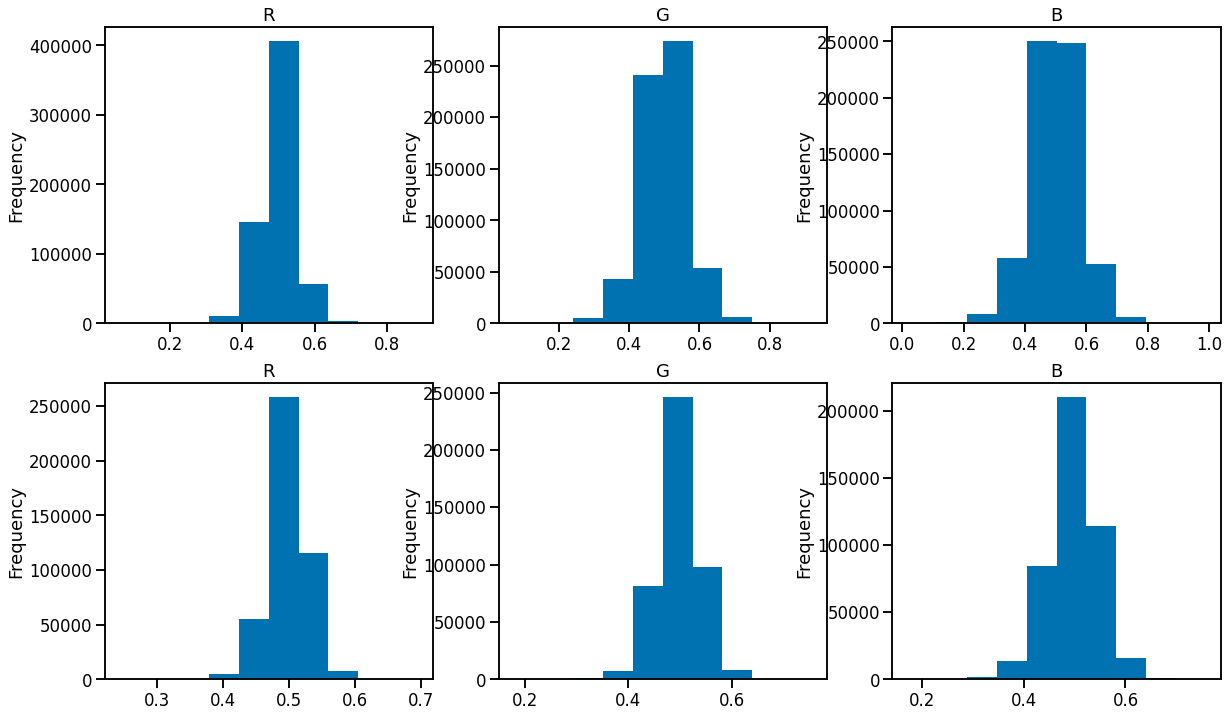

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3)
figsize=(20, 12)
oof_pred_df['target_r'].plot(kind='hist', ax=axes[0][0], figsize=figsize, title='R')
oof_pred_df['target_g'].plot(kind='hist', ax=axes[0][1], figsize=figsize, title="G")
oof_pred_df['target_b'].plot(kind='hist', ax=axes[0][2], figsize=figsize, title="B")
prediction['target_r'].plot(kind='hist', ax=axes[1][0], figsize=figsize, title='R')
prediction['target_g'].plot(kind='hist', ax=axes[1][1], figsize=figsize, title='G')
prediction['target_b'].plot(kind='hist', ax=axes[1][2], figsize=figsize, title='B')

In [18]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
